# Natural Language Processing with Disaster Tweets

## 1 Imports

In [124]:
%matplotlib inline
import numpy as np
from numpy import argmax
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from bs4 import BeautifulSoup
import re

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


## 2 Data exploration / plots

Reading in train.csv & test.csv.

In [125]:
df_train = pd.read_csv('CSV/train.csv')
df_test = pd.read_csv('CSV/test.csv')

In [126]:
X_train = df_train['text']
y_train = df_train['target']

X_train, y_train = shuffle(X_train, y_train, random_state=42)
id = df_test['id']

In [127]:
X_test = df_test['text']

In [128]:
df_train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


showing how many examples from the training set are a disaster (1), or no disaster (0)

In [129]:
df_train.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Visualising the disasters & non-disasters

C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\3112544263.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="target", data=df_train, palette=['lightgreen', 'salmon'])


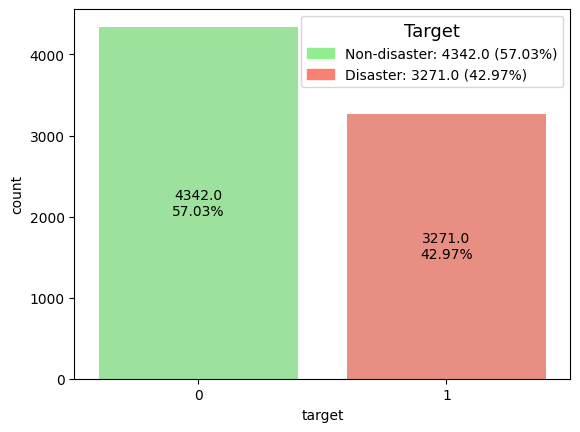

In [130]:
ax = sns.countplot(x="target", data=df_train, palette=['lightgreen', 'salmon'])

total = len(df_train)
labels = []
for p, label in zip(ax.patches, ['Non-disaster', 'Disaster']):
    count = p.get_height()
    pct = 100 * count / total
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.text(x, y, f'{count}\n{pct:.2f}%', ha='center', va='center')
    labels.append(f'{label}: {count} ({pct:.2f}%)')

patches = [mpatches.Patch(color=color, label=label) for color, label in zip(['lightgreen', 'salmon'], labels)]

plt.legend(handles=patches, title='Target', title_fontsize='13', fontsize='10')

plt.show()

Visualising the average length of a tweet.

<Axes: >

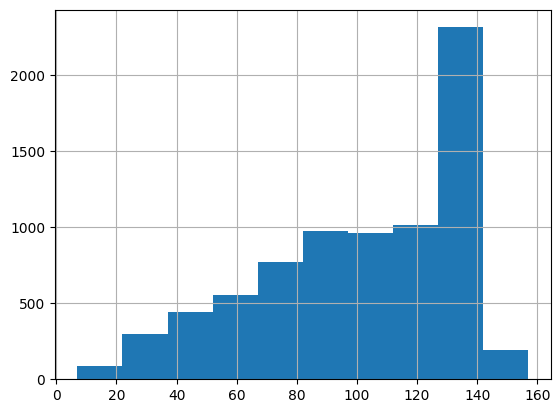

In [131]:
text_lengths = df_train['text'].apply(len)
text_lengths.hist()

In [132]:
df_train['char_len'] = df_train['text'].apply(len)

Visualising the average character length for a disaster.

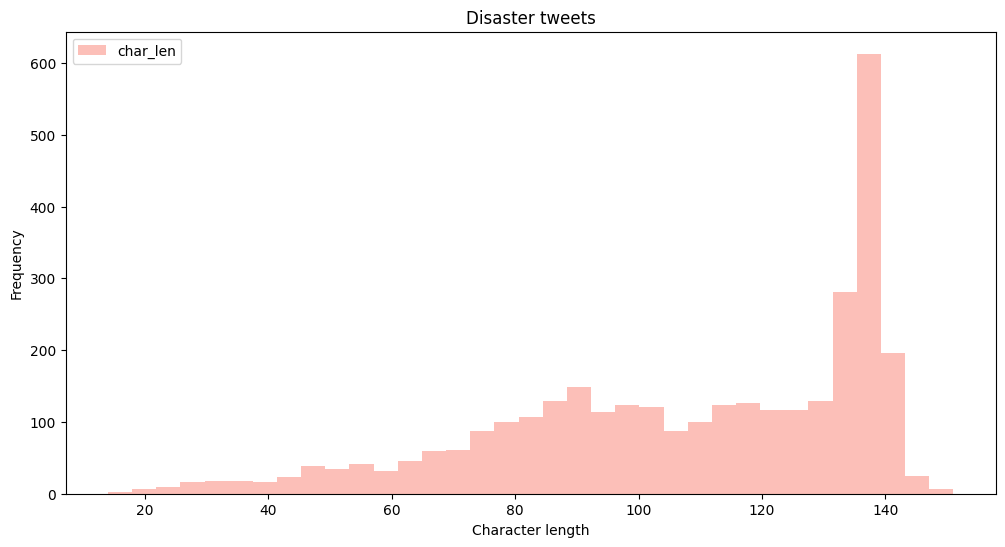

In [133]:
fig, ax = plt.subplots(figsize=(12, 6))

disaster_tweets = df_train.loc[df_train['target'] == 1, 'char_len']

disaster_tweets.plot(kind='hist', bins=35, color='salmon', alpha=0.5, ax=ax)

ax.set_xlabel("Character length")
ax.set_title("Disaster tweets")

ax.legend()

plt.show()

Visualising the average character length for a non-disaster.

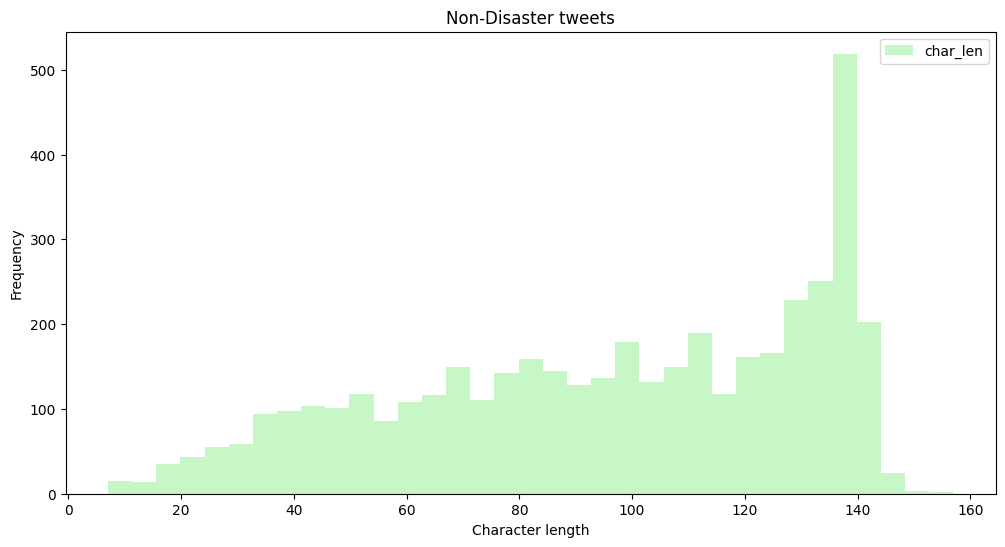

In [134]:
fig, ax = plt.subplots(figsize=(12, 6))

disaster_tweets = df_train.loc[df_train['target'] == 0, 'char_len']

disaster_tweets.plot(kind='hist', bins=35, color='lightgreen', alpha=0.5, ax=ax)

ax.set_xlabel("Character length")
ax.set_title("Non-Disaster tweets")

ax.legend()

plt.show()

In [135]:
df_train['word_len'] = df_train['text'].apply(lambda x: len(x.split()))

number of words in a tweet

<Axes: >

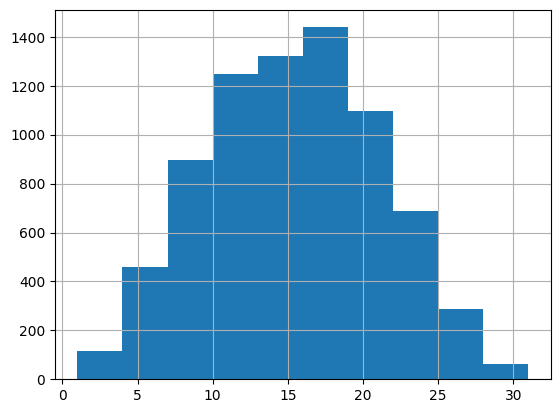

In [136]:
df_train['text'].apply(lambda x: len(x.split())).hist()

Visualising the average amount of words for a disaster tweet.

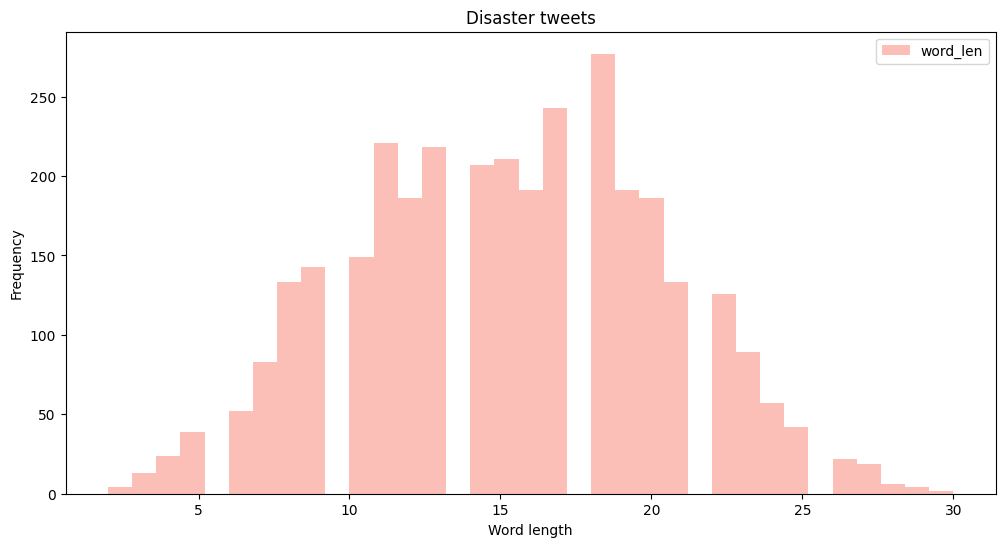

In [137]:
fig, ax = plt.subplots(figsize=(12, 6))
disaster_tweets_word_len = df_train.loc[df_train['target'] == 1, 'word_len']
disaster_tweets_word_len.plot(kind='hist', bins=35, color='salmon', alpha=0.5, ax=ax)
ax.set_xlabel("Word length")
ax.set_title("Disaster tweets")
ax.legend()
plt.show()

Visualising the average amount of words for a non-disaster tweet.

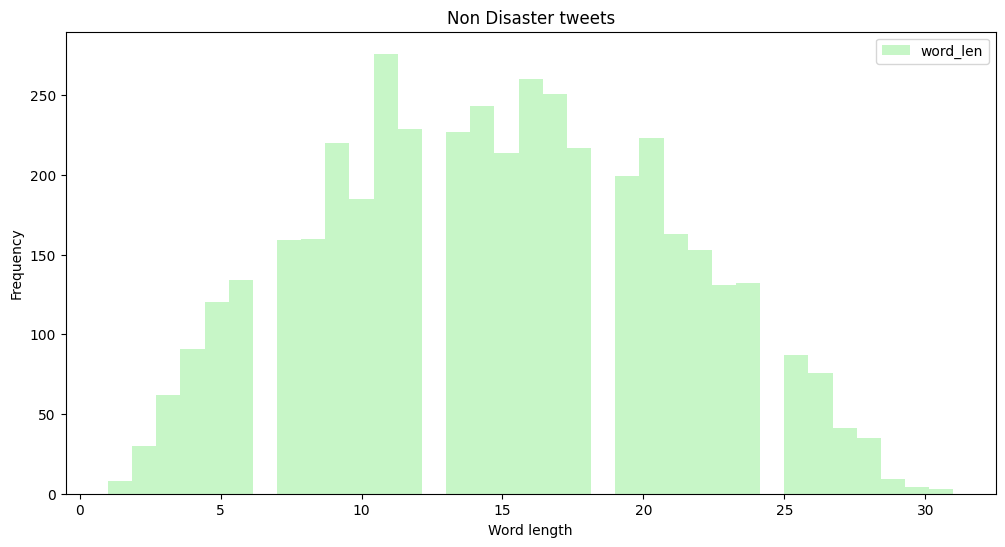

In [138]:
fig, ax = plt.subplots(figsize=(12, 6))
disaster_tweets_word_len = df_train.loc[df_train['target'] == 0, 'word_len']
disaster_tweets_word_len.plot(kind='hist', bins=35, color='lightgreen', alpha=0.5, ax=ax)
ax.set_xlabel("Word length")
ax.set_title("Non Disaster tweets")
ax.legend()
plt.show()

In [139]:
print("Disaster tweets \n")
df_train.loc[df_train.target == 1, ['char_len', 'word_len']].describe().transpose()

Disaster tweets 



,count,mean,std,min,25%,50%,75%,max
char_len,3271.0,108.236319,29.369513,14.0,88.0,115.0,136.0,151.0
word_len,3271.0,15.167533,5.096806,2.0,11.0,15.0,19.0,30.0


In [140]:
print("Non-Disaster tweets \n")
df_train.loc[df_train.target == 0, ['char_len', 'word_len']].describe().transpose()

Non-Disaster tweets 



,count,mean,std,min,25%,50%,75%,max
char_len,4342.0,95.832105,35.969652,7.0,68.0,101.0,130.0,157.0
word_len,4342.0,14.704744,6.161564,1.0,10.0,15.0,19.0,31.0


Visualising the 20 most used keywords in a disaster tweet.

C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\2026596371.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')


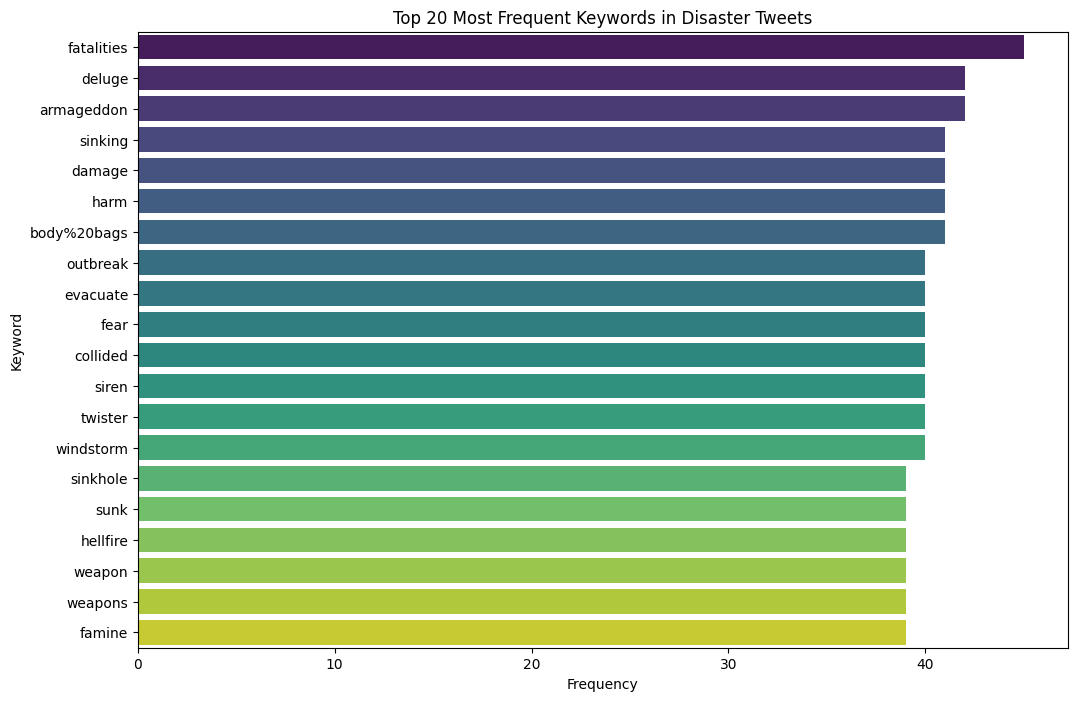

In [141]:
top_keywords = df_train['keyword'].value_counts().nlargest(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette='viridis')
plt.title('Top 20 Most Frequent Keywords in Disaster Tweets')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.show()


Visualising the 20 most used locations in a disaster tweet.

C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\408098678.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='mako')


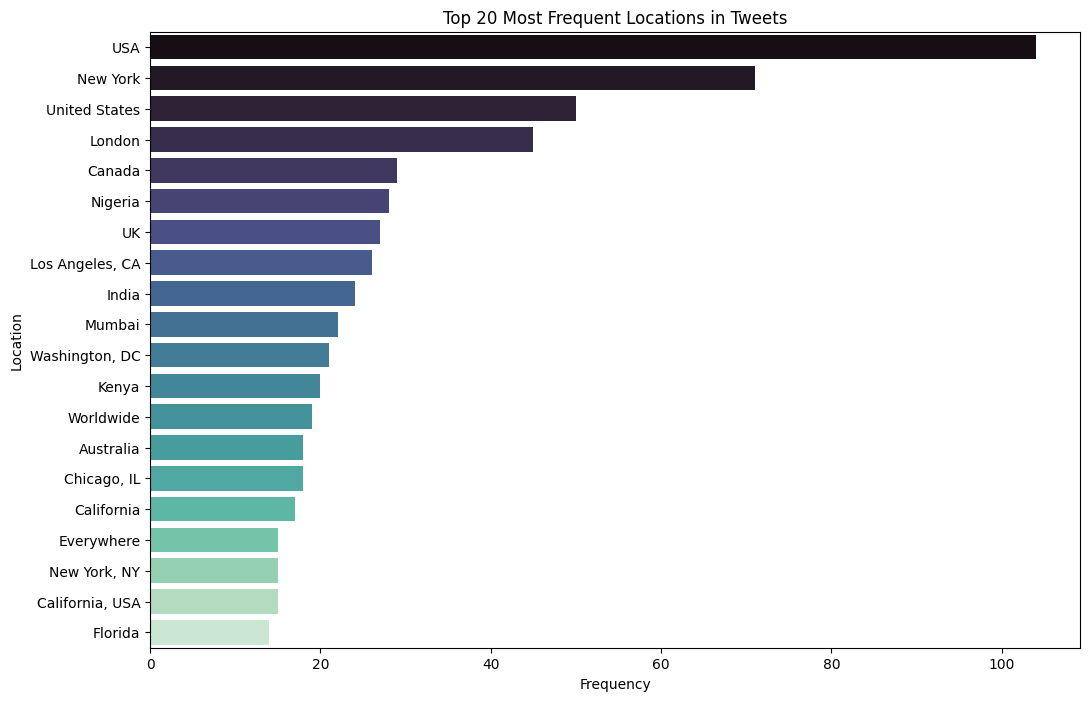

In [142]:
top_locations = df_train['location'].value_counts().nlargest(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_locations.values, y=top_locations.index, palette='mako')
plt.title('Top 20 Most Frequent Locations in Tweets')
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.show()


Showing the 20 most used keywords & wether they are a disaster or not.

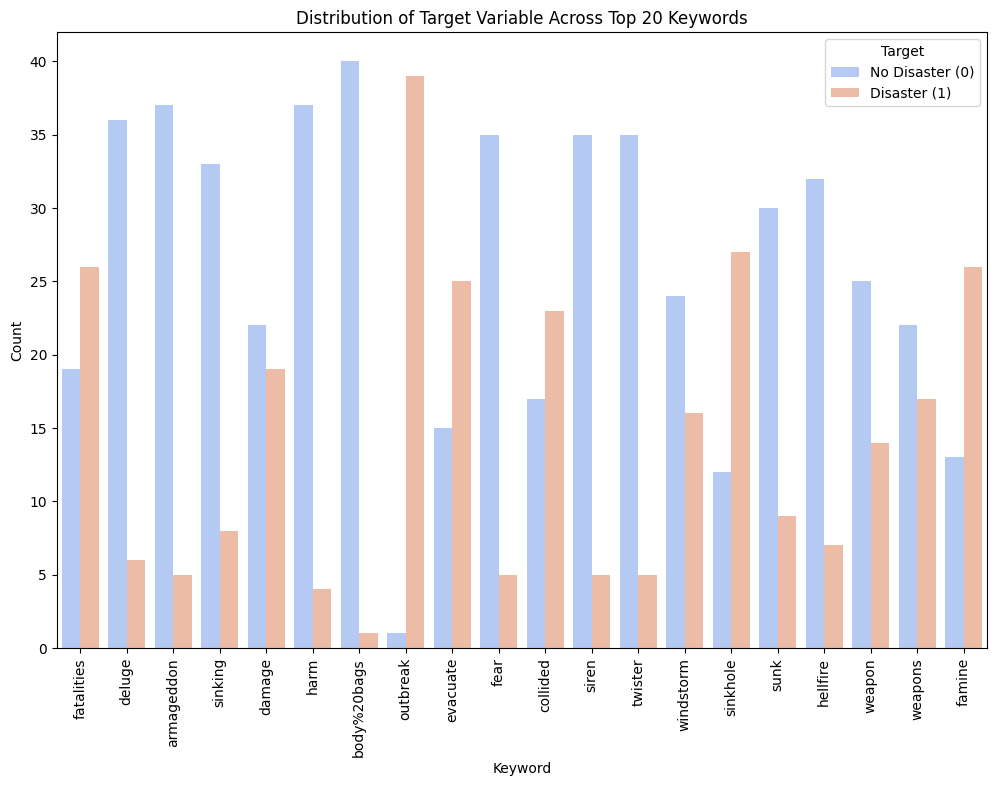

In [143]:
plt.figure(figsize=(12, 8))
sns.countplot(x='keyword', hue='target', data=df_train, order=df_train['keyword'].value_counts().iloc[:20].index, palette='coolwarm')
plt.title('Distribution of Target Variable Across Top 20 Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Target', labels=['No Disaster (0)', 'Disaster (1)'])
plt.show()


## 3 Text-preprocessing

In [144]:
def text_preprocessing(text, language, minWordSize):

    text_no_html = BeautifulSoup(text, "html.parser").get_text()

    text_no_url = re.sub(r'http\S+', ' ', text_no_html)

    text_no_at = ''
    for word in text_no_url.split():
        if not word.startswith('@'):  
            text_no_at = text_no_at + word + ' '
            
    text_no_RT = ''
    for word in text_no_at.split():
        if not word.startswith('RT'):  
            text_no_RT = text_no_RT + word + ' '         

    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_RT))

    text_lower = text_alpha_chars.lower()

    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    whitelist = ["n't", "not", "no"]
    for word in text_lower.split():
        if word not in stops or word in whitelist:  
            text_no_stop_words = text_no_stop_words + word + ' '

    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '

    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words

In [145]:
language = 'english'
minWordLength = 2
text_prep = np.empty

for i in range(X_train.shape[0]):
    X_train.iloc[i] = text_preprocessing(X_train.iloc[i], language, minWordLength)
    
    
for i in range(X_test.shape[0]):
    X_test.iloc[i] = text_preprocessing(X_test.iloc[i], language, minWordLength)

C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\3639917976.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text_no_html = BeautifulSoup(text, "html.parser").get_text()


C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\342931162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.iloc[i] = text_preprocessing(X_test.iloc[i], language, minWordLength)
C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\342931162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.iloc[i] = text_preprocessing(X_test.iloc[i], language, minWordLength)
C:\Users\GEVER\AppData\Local\Temp\ipykernel_11792\342931162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [146]:
X_train

2644                  new weapon caus un imagin destruct 
2227     ing thing gishwh got soak delug go pad tampon...
5448       dt col polic catch pickpocket liverpool stree 
132      aftershock back school kick great want thank ...
6845     respons trauma children addict develop defens...
                              ...                        
5226                 mani obliter server alway like play 
5390     panic attack bc enough money drug alcohol wan...
860      omron hem automat blood pressur monitor stand...
7603     offici say quarantin place alabama home possi...
7270     move england five year ago today whirlwind time 
Name: text, Length: 7613, dtype: object

In [147]:
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

In [148]:
count_vect = CountVectorizer()
X_train_bag_of_words = count_vect.fit_transform(X_train)
X_test_bag_of_words = count_vect.transform(X_test)


tfidf_transformer = TfidfTransformer()
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_bag_of_words)
X_train_tf = tf_transformer.transform(X_train_bag_of_words)
X_test_tf = tf_transformer.transform(X_test_bag_of_words)

## 4 Building Models

### 4.1 LSTM Model


In [149]:
model = LogisticRegression()
paramaters = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000, 100000]}                                       
             ]
                            
random_search = RandomizedSearchCV(estimator = model,  n_iter = 9, 
                           param_distributions = paramaters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)

random_search = random_search.fit(X_train_tf, y_train)

best_accuracy = random_search.best_score_ 
best_parameters = random_search.best_params_  

print('Best accuracy : ', random_search.best_score_)
print('Best parameters :', random_search.best_params_  )

Best accuracy :  0.8017858384814777
Best parameters : {'C': 1}


In [150]:
model = LogisticRegression()
paramaters = [{'C' : [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.08,1.09,1.1]}                                       
             ]
                            
grid_search = GridSearchCV(estimator = model, 
                           param_grid = paramaters,
                           scoring = 'accuracy',
                           cv = 4,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_tf, y_train)

best_accuracy = grid_search.best_score_ 
best_parameters = grid_search.best_params_  

print('Best accuracy : ', grid_search.best_score_)
print('Best parameters :', grid_search.best_params_  )

Best accuracy :  0.8025742745863452
Best parameters : {'C': 1.1}


In [151]:
max_fatures = 2000

tokenizer = Tokenizer(oov_token= True, num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train_clean)
X_train_tok = tokenizer.texts_to_sequences(X_train_clean)
X_test_tok = tokenizer.texts_to_sequences(X_test_clean)

X_train_tok = pad_sequences(X_train_tok)
X_test_tok = pad_sequences(X_test_tok,maxlen=X_train_tok.shape[1])

In [152]:
X_train_tok.shape

(7613, 23)

In [153]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train_class = to_categorical(y_train)

In [154]:
early_stopping =  EarlyStopping(patience=8,  restore_best_weights=True)

model = Sequential()
model.add(Embedding(input_dim=2000,output_dim =128, input_length = X_train_tok.shape[1]))
model.add(LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

history = model.fit(X_train_tok, y_train_class, epochs = 100, batch_size=16, verbose = 2, validation_split= 0.2,
                   callbacks=[early_stopping])

Epoch 1/100
381/381 - 19s - loss: 0.5106 - accuracy: 0.7514 - val_loss: 0.4611 - val_accuracy: 0.7892 - 19s/epoch - 51ms/step
Epoch 2/100
381/381 - 12s - loss: 0.3842 - accuracy: 0.8351 - val_loss: 0.4718 - val_accuracy: 0.7899 - 12s/epoch - 31ms/step
Epoch 3/100
381/381 - 12s - loss: 0.3424 - accuracy: 0.8567 - val_loss: 0.4769 - val_accuracy: 0.7938 - 12s/epoch - 31ms/step
Epoch 4/100
381/381 - 12s - loss: 0.2992 - accuracy: 0.8780 - val_loss: 0.5558 - val_accuracy: 0.7945 - 12s/epoch - 31ms/step
Epoch 5/100
381/381 - 13s - loss: 0.2469 - accuracy: 0.9016 - val_loss: 0.6083 - val_accuracy: 0.7879 - 13s/epoch - 34ms/step
Epoch 6/100
381/381 - 12s - loss: 0.2049 - accuracy: 0.9154 - val_loss: 0.7604 - val_accuracy: 0.7761 - 12s/epoch - 32ms/step
Epoch 7/100
381/381 - 13s - loss: 0.1688 - accuracy: 0.9302 - val_loss: 0.9261 - val_accuracy: 0.7649 - 13s/epoch - 35ms/step
Epoch 8/100
381/381 - 14s - loss: 0.1468 - accuracy: 0.9371 - val_loss: 0.8662 - val_accuracy: 0.7531 - 14s/epoch - 38

In [155]:
y_pred = model.predict(X_train_tok[int(len(X_train_tok)*0.8):])
y_pred = argmax(y_pred, axis=1)

y_true = argmax(y_train_class[int(len(y_train_class)*0.8):], axis=1)

print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1 score: {f1_score(y_true, y_pred)}')

48/48 [==============================] - 3s 22ms/step
Accuracy: 0.7892317793827971
Precision: 0.8565310492505354
Recall: 0.6116207951070336
F1 score: 0.7136485280999108


In [156]:
predictions_test = grid_search.predict(X_test_tf)

In [157]:
le = preprocessing.LabelEncoder()
le.fit(predictions_test)
predictions_test = le.transform(predictions_test)
predictions_test

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [158]:
df = pd.DataFrame({
    'id': id,
    'target': predictions_test
})

df['target'] = encoder.inverse_transform(df['target'])

print(df)

         id  target
0         0       1
1         2       1
2         3       1
3         9       1
4        11       1
...     ...     ...
3258  10861       1
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]


In [159]:
df.to_csv('CSV/predictionsLSTM.csv', index=False)

### 4.2 RNN Model

In [160]:
df = pd.read_csv('CSV/train.csv')

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=256)

labels = df['target'].values

split = int(len(data) * 0.7)
x_train, x_val = data[:split], data[split:]
y_train, y_val = labels[:split], labels[split:]

model2 = Sequential([
    Embedding(10000, 256),
    SimpleRNN(128, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

df_test = pd.read_csv('CSV/test.csv')

sequences_test = tokenizer.texts_to_sequences(df_test['text'])
data_test = pad_sequences(sequences_test, maxlen=256)

predictions_test2 = model2.predict(data_test)

predictions_test2 = predictions_test2.round().astype(int)

Epoch 1/10
167/167 [==============================] - 22s 122ms/step - loss: 0.6188 - accuracy: 0.6624 - val_loss: 0.5317 - val_accuracy: 0.7421
Epoch 2/10
167/167 [==============================] - 28s 170ms/step - loss: 0.2986 - accuracy: 0.8840 - val_loss: 0.5497 - val_accuracy: 0.7430
Epoch 3/10
167/167 [==============================] - 28s 170ms/step - loss: 0.1175 - accuracy: 0.9642 - val_loss: 0.6318 - val_accuracy: 0.7145
Epoch 4/10
167/167 [==============================] - 16s 97ms/step - loss: 0.0739 - accuracy: 0.9799 - val_loss: 0.6739 - val_accuracy: 0.7259
Epoch 5/10
167/167 [==============================] - 13s 77ms/step - loss: 0.0588 - accuracy: 0.9818 - val_loss: 0.6532 - val_accuracy: 0.7347
Epoch 6/10
167/167 [==============================] - 15s 91ms/step - loss: 0.0803 - accuracy: 0.9722 - val_loss: 0.8069 - val_accuracy: 0.7036
Epoch 7/10
167/167 [==============================] - 14s 81ms/step - loss: 0.0586 - accuracy: 0.9805 - val_loss: 0.7870 - val_accura

In [161]:
y_pred = model2.predict(x_val).round().astype(int)

print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'F1 score: {f1_score(y_val, y_pred)}')

72/72 [==============================] - 2s 30ms/step
Accuracy: 0.7246059544658494
Precision: 0.7159090909090909
Recall: 0.624380574826561
F1 score: 0.6670195870831127


In [162]:
predictions_test2 = predictions_test2.flatten()

In [163]:
df2 = pd.DataFrame({
    'id': id,
    'target': predictions_test2
})

df2['target'] = encoder.inverse_transform(df2['target'])

print(df2)

         id  target
0         0       1
1         2       1
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]


In [164]:
df2.to_csv('CSV/predictionsRNN.csv', index=False)

## 5 Model Comparisons

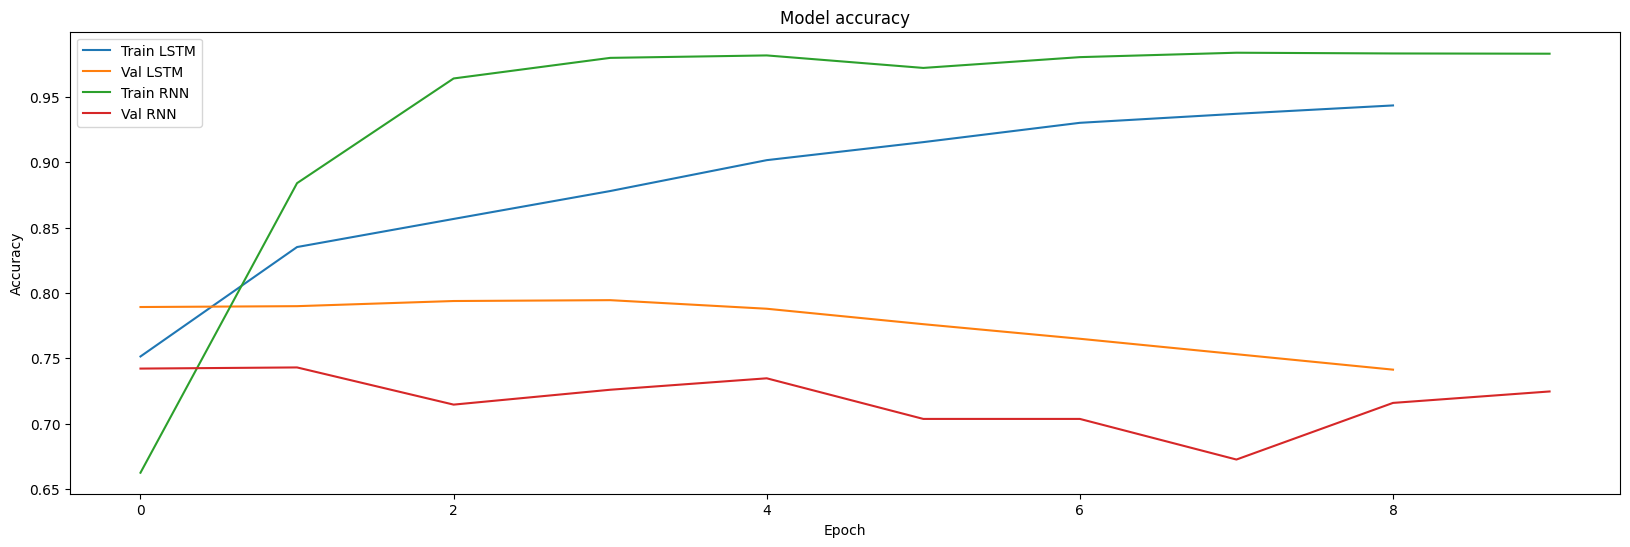

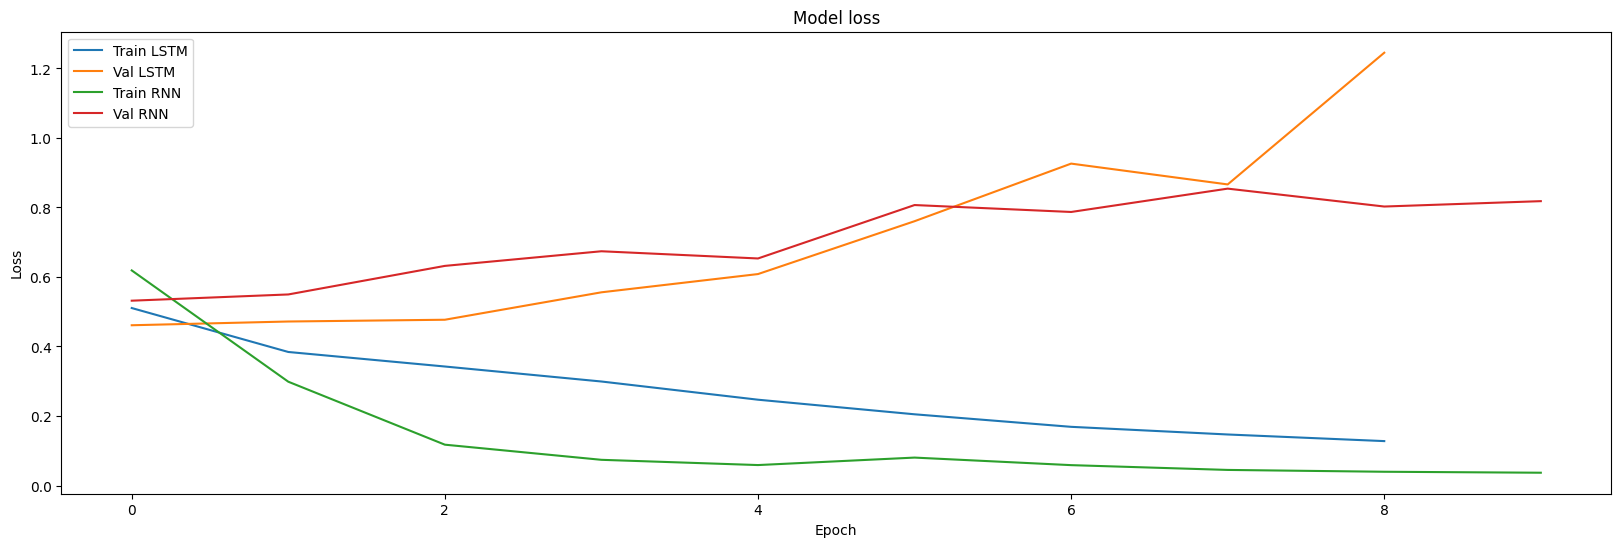

In [165]:
plt.figure(figsize=(20, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train LSTM', 'Val LSTM', 'Train RNN', 'Val RNN'], loc='upper left')
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train LSTM', 'Val LSTM', 'Train RNN', 'Val RNN'], loc='upper left')
plt.show()